In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.6.2
keras.api._v2.keras 2.6.0


In [3]:
# fashion_mnist图像分类数据集
fashion_mnist = keras.datasets.fashion_mnist

(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_valid, x_train = x_train_all[:5000], x_train_all[5000:]  # 自定义验证集样本数量5000
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# 得到的是np，训练集，验证集，测试集
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [4]:
28*28  # 如果非要对应多少特征，就是784个特征

784

In [5]:
type(x_train)

numpy.ndarray

In [6]:
y_train[0]

4

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 196 21

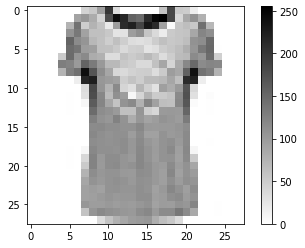

184
0


In [7]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.colorbar()  # 旁边显示一个色阶条
    plt.show()


# 依次看一下x_train[0]，x_train[1]，x_train[2]就可以理解下面的循环
print(x_train[0])
show_single_image(x_train[1])
print(x_train[1,0,18])
print(y_train[1])

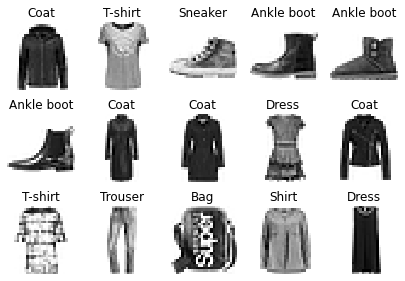

In [8]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)  # 断言：x和y的样本数一致（可以预料到的异常）
    assert n_rows * n_cols < len(x_data)  # 确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  # 宽1.4高1.6
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)  # 因为从1开始
            plt.imshow(x_data[index], cmap="binary",
                       interpolation = 'nearest')
            plt.axis('off')  # 去除坐标系
            plt.title(class_names[y_data[index]])
    plt.show()
# 已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
# 只是打印了前15个样本
show_imgs(3, 5, x_train, y_train, class_names)


In [9]:
# tf.keras.models.Sequential(),可以看下官网
# 功能：Sequential将线性的层堆叠到一个tf.keras.Model

model = keras.models.Sequential()
# 把28*28的图片展平为一个一维向量,通过下面打印可以看到两个相乘
model.add(keras.layers.Flatten(input_shape=[28, 28]))
print(model.output_shape)

# Dense是全连接层，添加全连接层，单元数是300，可以对比300和100的差异
# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# 另一种实现方式
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])



# reason for sparse: y->index. y->one_hot->[] 
# loss是损失函数 y如果只是一个数，那么使用sparse_categorical_crossentropy
# sparse_categorical_crossentropy计算稀疏分类crossentropy损失
# 计算的分类值是 0,1,2,...9
# 如果是一个向量，那么使用categorical_crossentropy
# optimizer是优化方法，
# metrics：模型在训练和测试期间要评估的指标列表（算子）
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

(None, 784)


In [10]:
model.layers  #总计有4层

In [11]:
# 计算参数个数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
784*300+300

235500

In [13]:
model.variables  # 模型中自己训练的参数

[<tf.Variable 'dense/kernel:0' shape=(784, 300) dtype=float32, numpy=
 array([[ 0.06382512,  0.02635588, -0.03967408, ...,  0.00196544,
          0.0353009 ,  0.02244373],
        [-0.06620544,  0.00045069, -0.01344121, ..., -0.02563372,
          0.06692927,  0.01708721],
        [-0.02556816,  0.01554631,  0.04291801, ...,  0.0024805 ,
          0.02317974,  0.01921599],
        ...,
        [ 0.06816381, -0.07344374, -0.03689073, ..., -0.01960803,
          0.04787016,  0.05913012],
        [ 0.0220511 , -0.06330337,  0.05481556, ..., -0.07241961,
          0.02366319,  0.05152264],
        [-0.04301921, -0.0390811 , -0.00039914, ...,  0.0218527 ,
          0.06341067,  0.06149842]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(300,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
# 均匀分布
np.sqrt(6/300)

0.1414213562373095

In [15]:
model.variables[0].numpy().max()

0.07439794

In [16]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]
# W是矩阵，b是一个偏置，是一个向量

In [17]:
# 训练20次，每一次所有的样本都输进去（再分成默认32批次）
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))  

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 2.8091 - accuracy: 0.7018 - val_loss: 0.6819 - val_accuracy: 0.7738
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5984 - accuracy: 0.7835 - val_loss: 0.5694 - val_accuracy: 0.8042
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5206 - accuracy: 0.8082 - val_loss: 0.5383 - val_accuracy: 0.8126
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4801 - accuracy: 0.8241 - val_loss: 0.5015 - val_accuracy: 0.8284
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4518 - accuracy: 0.8349 - val_loss: 0.5047 - val_accuracy: 0.8304
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4320 - accuracy: 0.8417 - val_loss: 0.4800 - val_accuracy: 0.8348
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4153 - accuracy: 0.8467 - val_loss: 0.4781 - val_accuracy:

In [18]:
type(history)

keras.callbacks.History

In [19]:
# 十次历史的信息
history.history

{'loss': [2.8090739250183105,
  0.5984344482421875,
  0.5205665230751038,
  0.48008137941360474,
  0.45180022716522217,
  0.43199217319488525,
  0.41532063484191895,
  0.40294864773750305,
  0.3916361629962921,
  0.38295674324035645,
  0.3747878968715668,
  0.3675910532474518,
  0.3624736964702606,
  0.35382670164108276,
  0.3489149212837219,
  0.34398648142814636,
  0.3380265235900879,
  0.33204013109207153,
  0.32865941524505615,
  0.32432788610458374],
 'accuracy': [0.7017818093299866,
  0.7834727168083191,
  0.8082000017166138,
  0.8241090774536133,
  0.8349454402923584,
  0.8417272567749023,
  0.8466727137565613,
  0.8513091206550598,
  0.8547636270523071,
  0.8595454692840576,
  0.8601272702217102,
  0.8643817901611328,
  0.8649818301200867,
  0.8684181571006775,
  0.8698363900184631,
  0.87132728099823,
  0.8736909031867981,
  0.87616366147995,
  0.8760908842086792,
  0.8792726993560791],
 'val_loss': [0.6818614602088928,
  0.5694378614425659,
  0.5382954478263855,
  0.501545667

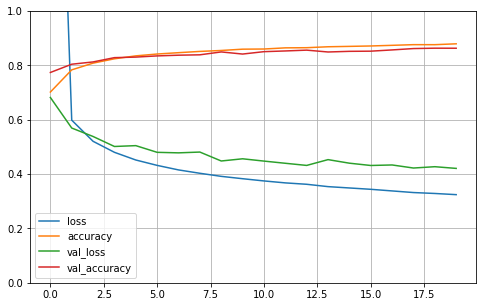

In [20]:
# 画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))  # 使用df中的折线图绘制
    plt.grid(True)
    plt.gca().set_ylim(0, 1)  # 纵坐标的刻度范围
    plt.show()

plot_learning_curves(history)  # 横坐标是epochs

In [21]:
# 在测试集上评估，一个是测试集的损失，一个是测试集的准确率
model.evaluate(x_test, y_test, verbose=0)

[0.4614326059818268, 0.8468000292778015]

In [5]:
# 计算标签和预测之间的crossentropy(交叉熵)损失
cce = keras.losses.SparseCategoricalCrossentropy()
loss = cce(
  [0, 1, 2],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss: ', loss.numpy())  

Loss:  0.09458992


In [6]:
# softmax手动计算
import numpy as np
z = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0])
m=np.exp(z)/sum(np.exp(z))
sum(m)

0.9999999999999999

In [10]:
np.log2(8)

3.0

In [17]:
np.log(np.e * np.e)

2.0